# Depth Model Evaluation with MonoDepth2

### Boilerplate

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from yolov4.tf import YOLOv4
import time
import tensorflow as tf

Call tf.config.experimental.set_memory_growth(GPU0, True)


In [2]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Load the MonoDepth2 model 

In [3]:
model_name = "mono+stereo_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

In [4]:
image_path = "assets/test_image.jpg"

In [5]:
def preprocess_image(image_path):
    
    input_image = pil.open(image_path).convert('RGB')
    original_width, original_height = input_image.size

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    
    return input_image ,input_image_pytorch, original_width, original_height
    

In [6]:
def depth_predict(input_image_pytorch,original_width, original_height) :
    

    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]
    
    disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)
    
    return disp_resized_np,vmax

In [39]:
# disp_resized = torch.nn.functional.interpolate(disp,
#     (original_height, original_width), mode="bilinear", align_corners=False)

# # Saving colormapped depth image
# disp_resized_np = disp_resized.squeeze().cpu().numpy()
# vmax = np.percentile(disp_resized_np, 95)

# plt.figure(figsize=(10, 10))
# plt.subplot(211)
# plt.imshow(input_image)
# plt.title("Input", fontsize=22)
# plt.axis('off')

# plt.subplot(212)
# plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
# plt.title("Disparity prediction", fontsize=22)
# plt.axis('off');

## Compare depthModel performances with Kitti Dataset 

#### load the kitti images and label data 

There are 6 images


Text(0.5, 1.0, 'Image Right')

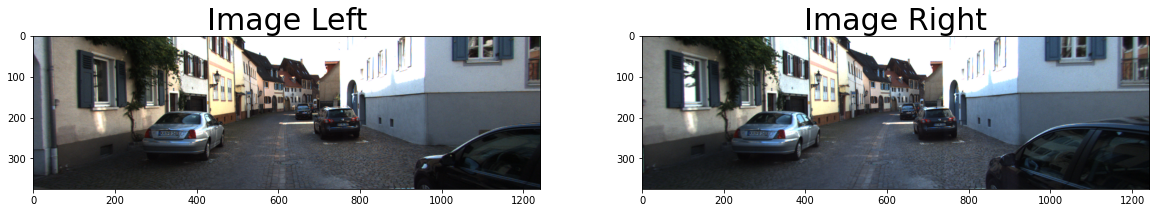

In [7]:
images_L = sorted(glob.glob("kitti_dataset/data/left/*.png"))
images_R =  sorted(glob.glob("kitti_dataset/data/right/*.png"))
labels =  sorted(glob.glob("kitti_dataset/data/labels/*.txt"))
calib_files =  sorted(glob.glob("kitti_dataset/data/calib/*.txt"))

print("There are",len(images_L),"images")

index = 5

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(cv2.imread(images_L[index]), cv2.COLOR_BGR2RGB))
ax1.set_title('Image Left', fontsize=30)
ax2.imshow(cv2.cvtColor(cv2.imread(images_R[index]), cv2.COLOR_BGR2RGB))
ax2.set_title('Image Right', fontsize=30)

Text(0.5, 1.0, 'Disparity prediction')

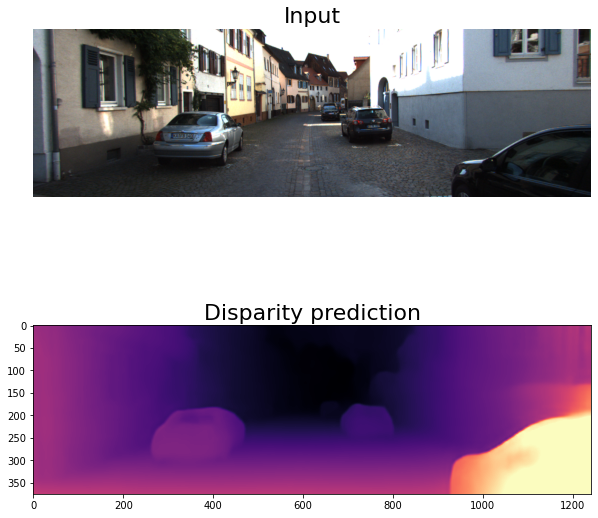

In [17]:
def ground_truth_display(img_label, index,depth_map):
    
    with open(labels[index], 'r') as f:
            fin = f.readlines()
            for line in fin:
                if line.split(" ")[0] != "DontCare":
                    print(line)
                    x1_value = int(float(line.split(" ")[4]))
                    y1_value = int(float(line.split(" ")[5]))
                    x2_value = int(float(line.split(" ")[6]))
                    y2_value = int(float(line.split(" ")[7]))
                    distance = float(line.split(" ")[13])
                    print(x1_value,y1_value,x2_value,y2_value)
                    
                    obstacle_depth = depth_map[y1_value:y2_value, x1_value:x2_value]
     
                    xc_value = int(x1_value + ((x2_value - x1_value)/2))
                    
                    yc_value = int(y1_value + ((y2_value - y1_value)/2))
 
                    depth_ = depth_map[yc_value][xc_value]
                    
                    pred_distance =  "{:.2f}".format(depth_)
               
                    cv2.rectangle(img_label, (x1_value, y1_value), (x2_value, y2_value), (255,205,0), 2)
                    cv2.putText(img_label, str(distance), (int((x1_value+x2_value)/2),int((y1_value+y2_value)/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                    cv2.putText(img_label, str(pred_distance), (int(((x1_value+x2_value)/2)+58),int((y1_value+y2_value)/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
                    
    return img_label



# Pre process the image 
orig_img , img_ , w, h = preprocess_image(images_L[index])


# depth Predict
disp_resized_np,vmax = depth_predict(img_,w, h)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(orig_img)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)


In [9]:
def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

In [10]:
scaled_disp, depth = disp_to_depth(disp_resized_np, 0.1, 100)

In [13]:
depth

array([[1.2501956 , 1.2495832 , 1.248429  , ..., 1.1060426 , 1.1066749 ,
        1.1070101 ],
       [1.2491689 , 1.2486066 , 1.2475463 , ..., 1.1053382 , 1.1060485 ,
        1.106425  ],
       [1.2472123 , 1.246745  , 1.2458637 , ..., 1.103995  , 1.104854  ,
        1.1053094 ],
       ...,
       [1.0233096 , 1.025913  , 1.0308644 , ..., 0.39847842, 0.39685798,
        0.39600497],
       [1.0201232 , 1.0228049 , 1.0279063 , ..., 0.3978003 , 0.39620405,
        0.3953638 ],
       [1.0184633 , 1.0211856 , 1.0263648 , ..., 0.39744624, 0.39586267,
        0.395029  ]], dtype=float32)

In [18]:
def ground_truth_display(img_label, index,depth_map):
    with open(labels[index], 'r') as f:
            fin = f.readlines()
            for line in fin:
                if line.split(" ")[0] != "DontCare":
                    print(line)
                    x1_value = int(float(line.split(" ")[4]))
                    y1_value = int(float(line.split(" ")[5]))
                    x2_value = int(float(line.split(" ")[6]))
                    y2_value = int(float(line.split(" ")[7]))
                    distance = float(line.split(" ")[13])
                    print(x1_value,y1_value,x2_value,y2_value)
                    
                    obstacle_depth = depth_map[y1_value:y2_value, x1_value:x2_value]
     
                    xc_value = int(x1_value + ((x2_value - x1_value)/2))
                    
                    yc_value = int(y1_value + ((y2_value - y1_value)/2))
 
                    depth_ = depth_map[yc_value][xc_value]
                    
                    pred_distance =  "{:.2f}".format(depth_)
               
                    cv2.rectangle(img_label, (x1_value, y1_value), (x2_value, y2_value), (255,205,0), 2)
                    cv2.putText(img_label, str(distance), (int((x1_value+x2_value)/2),int((y1_value+y2_value)/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
                    cv2.putText(img_label, str(pred_distance), (int(((x1_value+x2_value)/2)+58),int((y1_value+y2_value)/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
                    
    return img_label

Car 0.00 0 -1.75 683.34 170.98 803.44 257.43 1.49 1.56 4.34 2.51 1.49 14.75 -1.59

683 170 803 257
Car 0.00 0 -1.31 262.97 182.23 469.76 318.00 1.42 1.53 4.12 -3.06 1.56 9.79 -1.61

262 182 469 318
Car 0.99 1 -2.37 910.25 159.81 1241.00 374.00 1.59 1.59 3.89 2.61 1.55 2.39 -1.60

910 159 1241 374
Car 0.00 0 -1.58 641.55 172.79 681.44 206.29 1.38 1.64 3.51 2.22 1.40 31.72 -1.51

641 172 681 206
Van 0.00 2 -1.24 683.63 153.82 724.01 183.67 2.59 1.98 5.33 8.59 0.95 65.64 -1.11

683 153 724 183


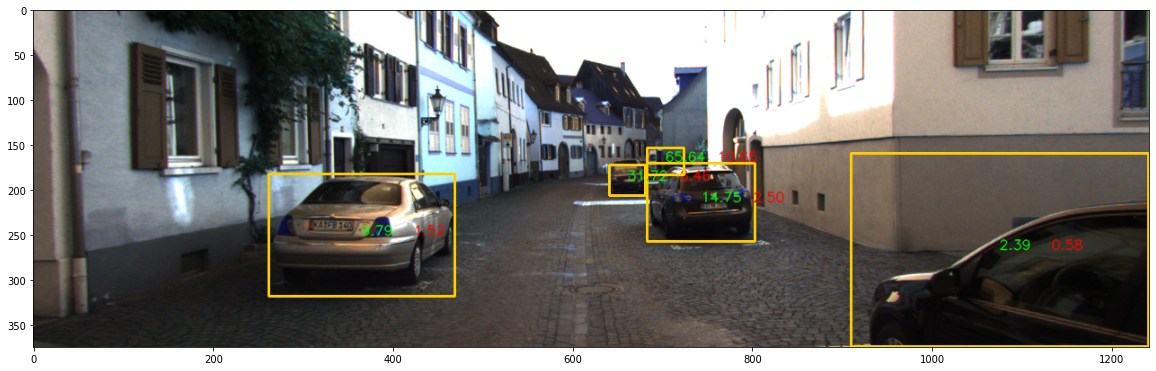

In [15]:
img = cv2.imread(images_L[index])
img_label = ground_truth_display(img, index,depth)


plt.figure(figsize=(20,40))
plt.imshow(img_label)
plt.show()